<a href="https://colab.research.google.com/github/yesh6289/credit_card_fraud_detection/blob/main/A_N_D_major_project_credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the required datasets

We will be using TensorFlow 1.2 and Keras 2.0.4. Let's begin:

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Loading the data:

In [4]:
df = pd.read_csv("card_transdata.csv")

Exploration:

In [6]:
df.shape

(1000000, 8)

In [7]:
df.isnull().values.any()

False

In [11]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Text(0, 0.5, 'Frequency')

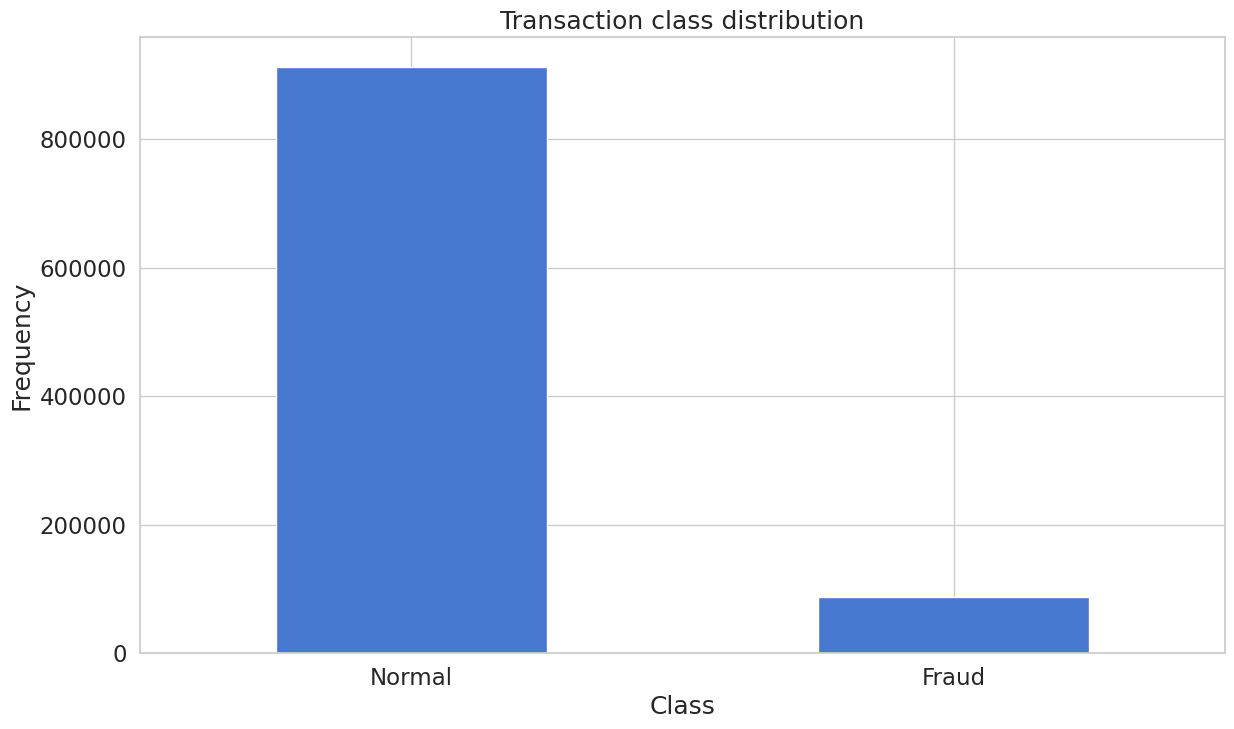

In [12]:
count_classes = pd.value_counts(df['fraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [14]:
frauds = df[df.fraud == 1]
normal = df[df.fraud == 0]

In [16]:
frauds.shape

(87403, 8)

In [17]:
normal.shape

(912597, 8)

How different are the amount of money used in different transaction classes?

In [19]:
frauds.distance_from_home.describe()

count    87403.000000
mean        66.261876
std        134.391608
min          0.025847
25%          4.585729
50%         15.454219
75%        101.110104
max      10632.723672
Name: distance_from_home, dtype: float64

In [20]:
normal.distance_from_home.describe()

count    912597.000000
mean         22.832976
std          52.828655
min           0.004874
25%           3.828942
50%           9.673847
75%          24.158057
max        8777.136420
Name: distance_from_home, dtype: float64

Graphical representation

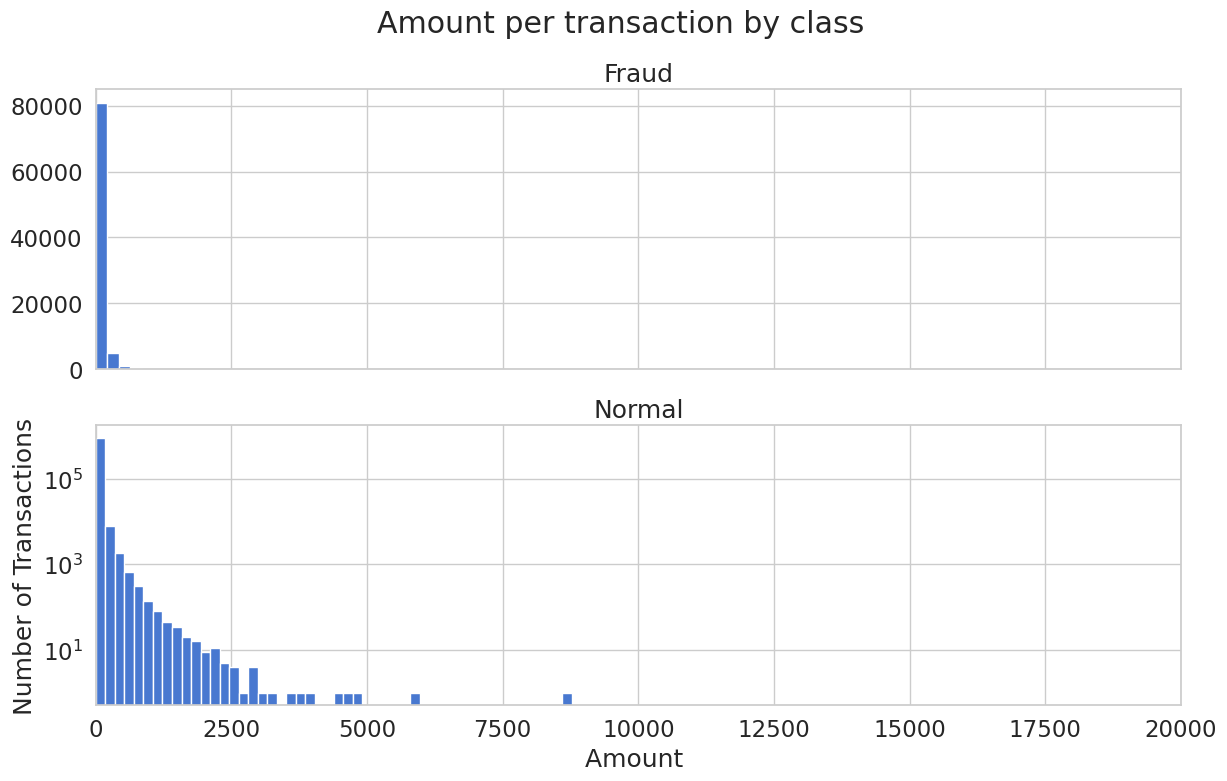

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.distance_from_home, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.distance_from_home, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Autoencoders
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:


While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.

Here's a visual representation of what an Autoencoder might learn:



Reconstruction error
We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:


If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:

Preparing the data
First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [24]:
from sklearn.preprocessing import StandardScaler

data = df

data['distance_from_home'] = StandardScaler().fit_transform(data['distance_from_home'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [26]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.fraud == 0]
X_train = X_train.drop(['fraud'], axis=1)

y_test = X_test['fraud']
X_test = X_test.drop(['fraud'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [27]:
X_train.shape

(730040, 7)

Building the model
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [28]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [29]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [30]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
22814/22814 [==============================] - 92s 4ms/step - loss: 64.9622 - accuracy: 0.8320 - val_loss: 53.8355 - val_accuracy: 0.8412
Epoch 2/100
   80/22814 [..............................] - ETA: 43s - loss: 14.8482 - accuracy: 0.8289

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



22814/22814 [==============================] - 92s 4ms/step - loss: 57.7603 - accuracy: 0.8549 - val_loss: 46.6855 - val_accuracy: 0.8529
Epoch 3/100
22814/22814 [==============================] - 79s 3ms/step - loss: 54.5289 - accuracy: 0.8627 - val_loss: 42.0730 - val_accuracy: 0.9063
Epoch 4/100
22814/22814 [==============================] - 91s 4ms/step - loss: 52.6065 - accuracy: 0.8541 - val_loss: 38.8688 - val_accuracy: 0.7974
Epoch 5/100
22814/22814 [==============================] - 89s 4ms/step - loss: 50.9959 - accuracy: 0.8451 - val_loss: 36.3200 - val_accuracy: 0.8403
Epoch 6/100
22814/22814 [==============================] - 81s 4ms/step - loss: 49.9129 - accuracy: 0.8273 - val_loss: 34.9966 - val_accuracy: 0.8884
Epoch 7/100
22814/22814 [==============================] - 77s 3ms/step - loss: 48.7200 - accuracy: 0.8191 - val_loss: 32.5010 - val_accuracy: 0.9161
Epoch 8/100
22814/22814 [==============================] - 67s 3ms/step - loss: 47.8888 - accuracy: 0.8313 - val

In [32]:
autoencoder = load_model('model.h5')


Evaluation

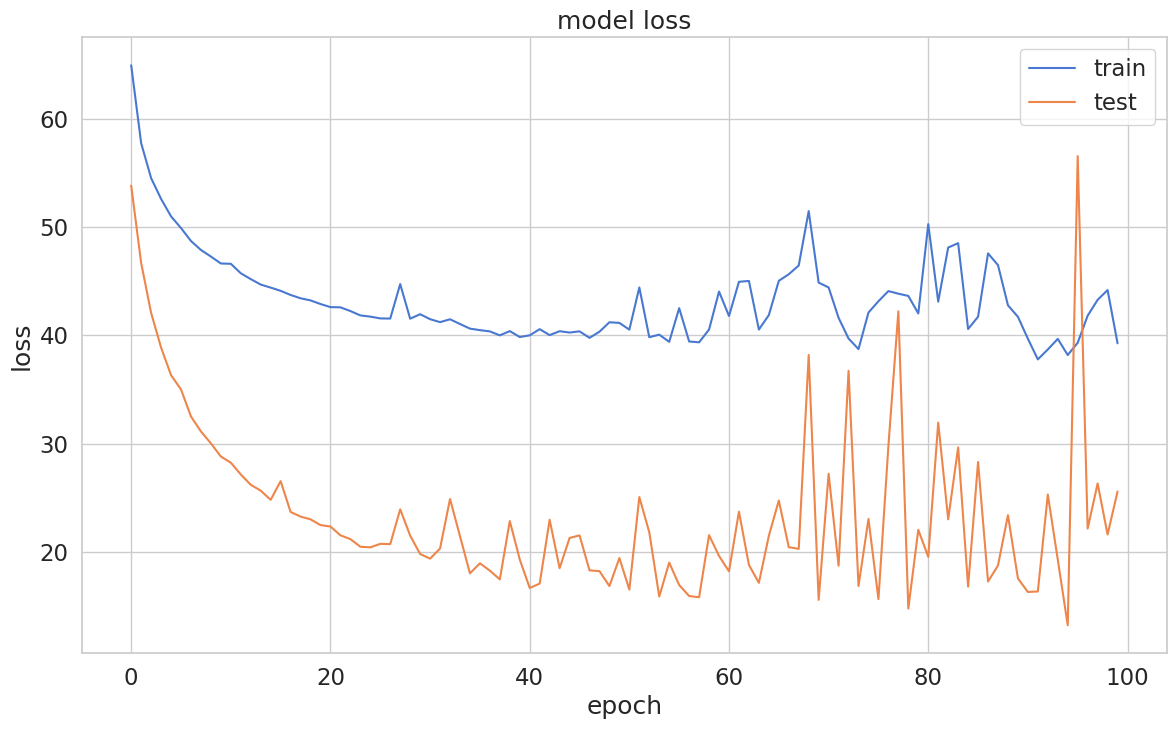

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [34]:
predictions = autoencoder.predict(X_test)

6250/6250 [==============================] - 10s 2ms/step


In [35]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [36]:

error_df.describe()

,reconstruction_error,true_class
count,200000.000000,200000.000000
mean,13.203647,0.087215
std,1860.768561,0.282151
min,0.030834,0.000000
25%,0.197376,0.000000
50%,0.299881,0.000000
75%,0.531802,0.000000
max,613600.553444,1.000000


Reconstruction error without fraud

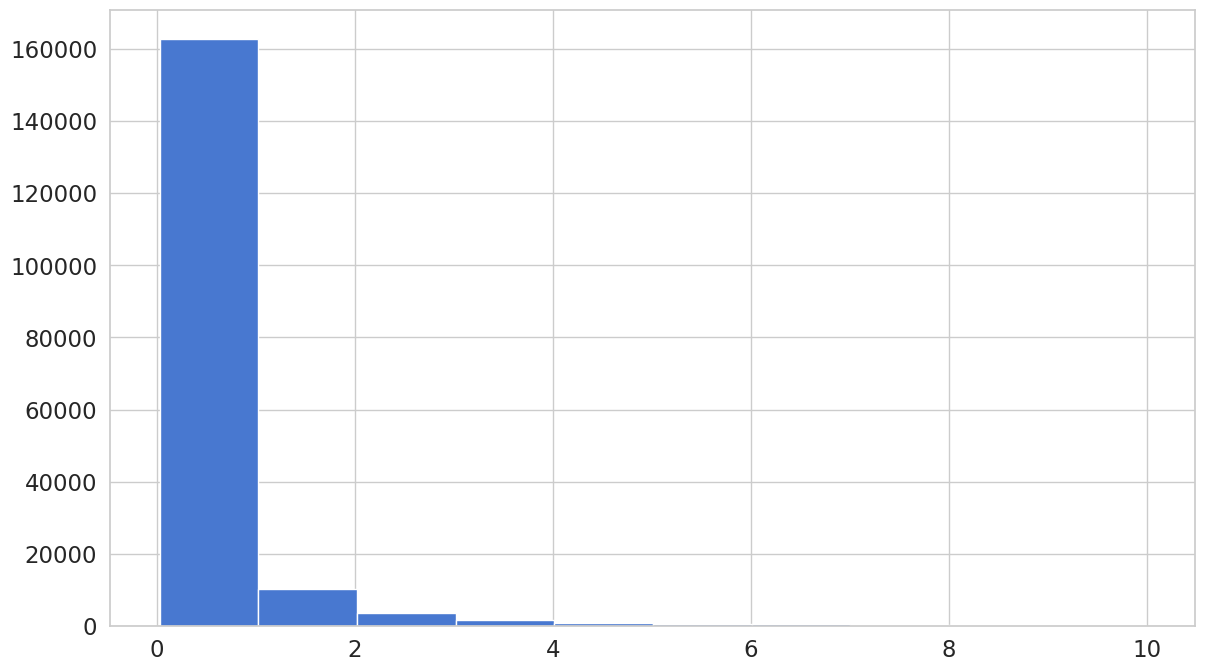

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


Reconstruction error with fraud

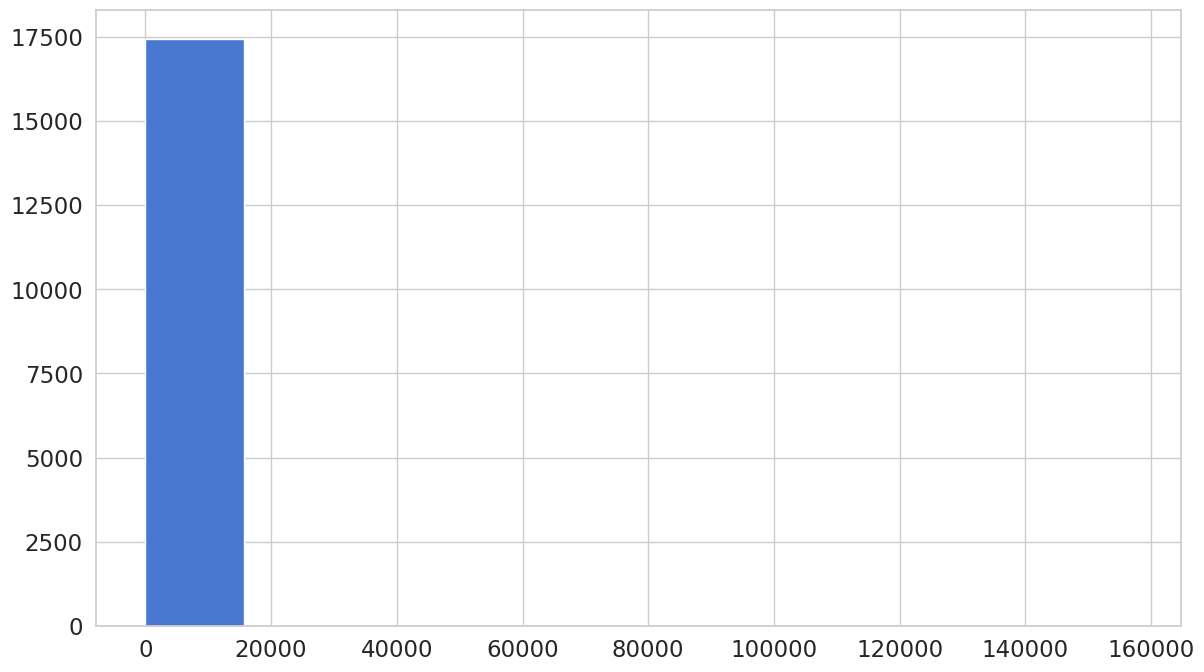

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [40]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

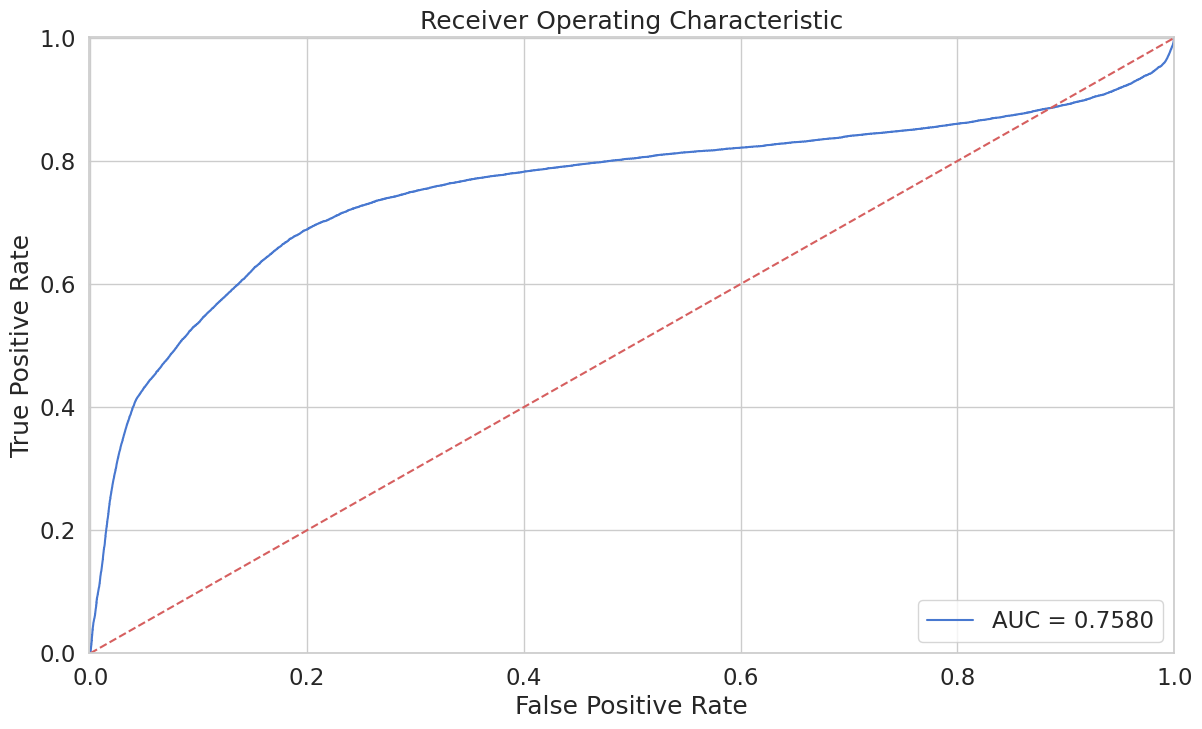

In [41]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

Precision and recall are defined as follows:





Let's take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let's return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

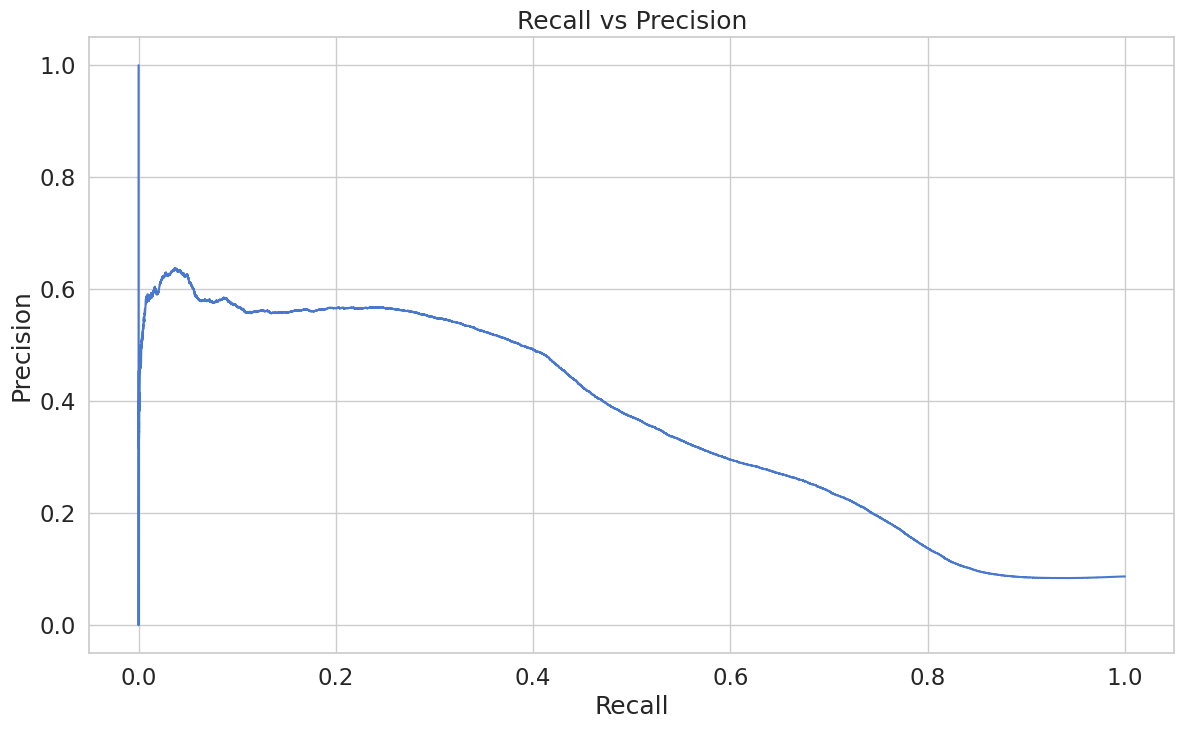

In [42]:

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

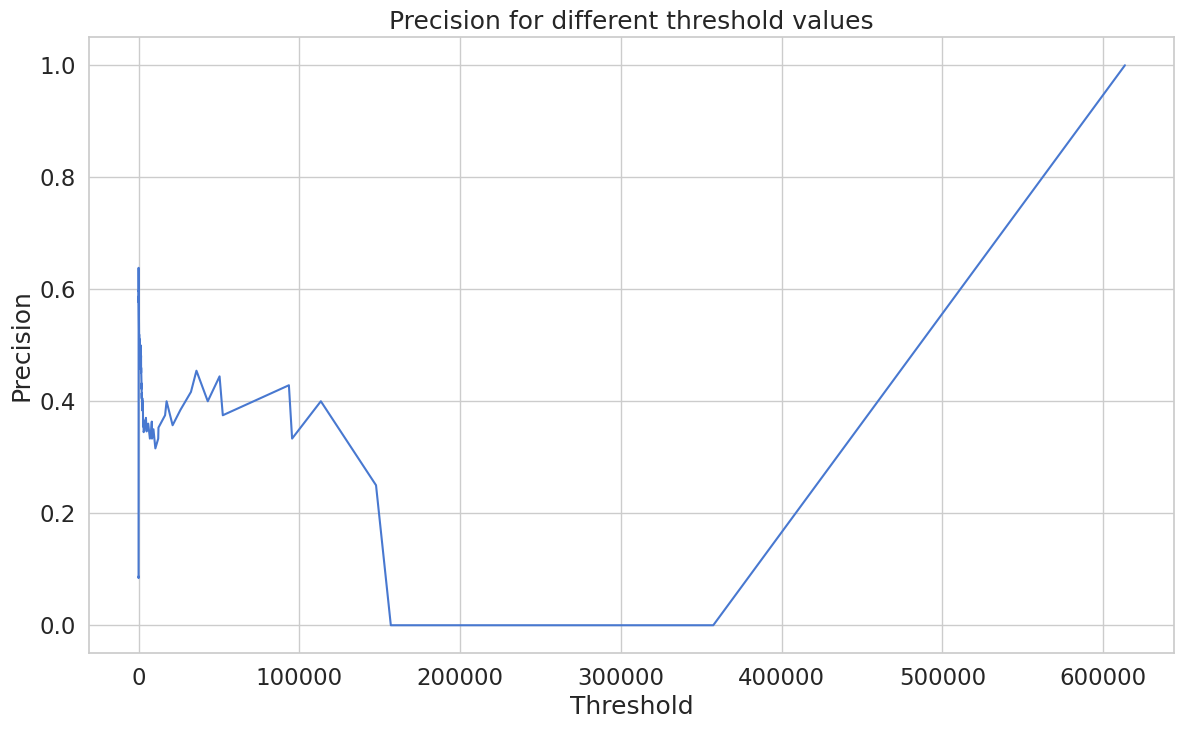

In [43]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()


You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

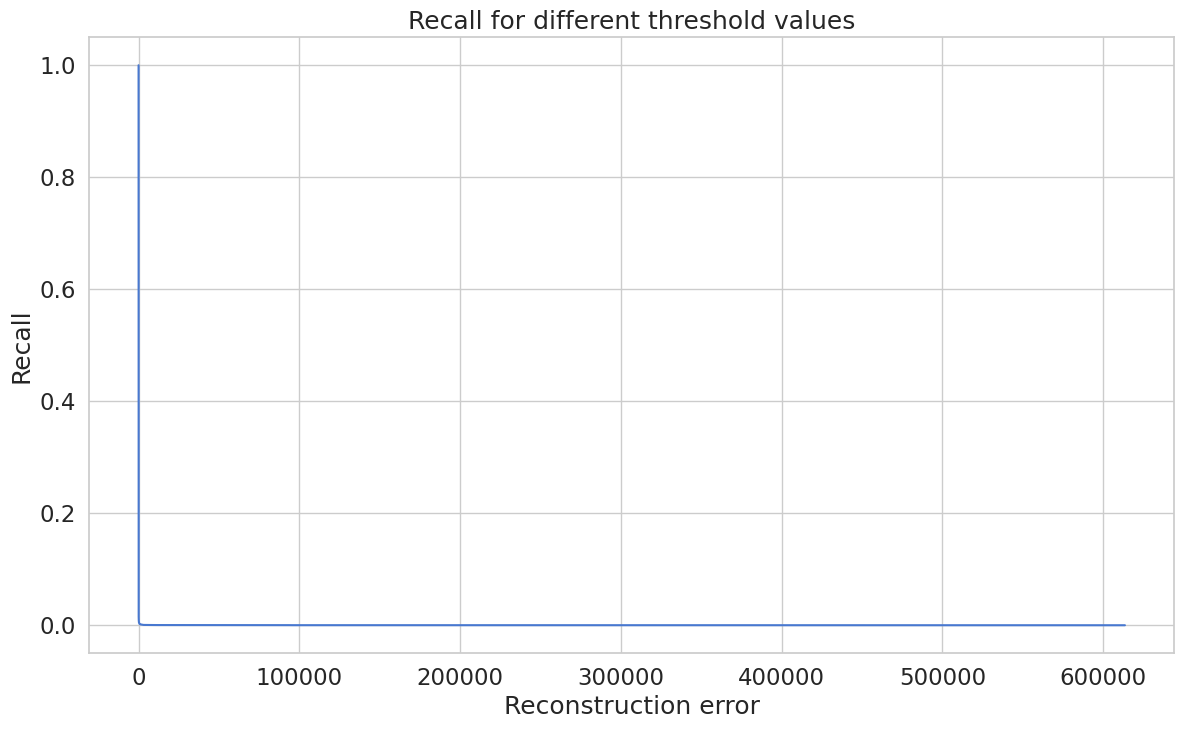

In [44]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

Prediction
Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [45]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

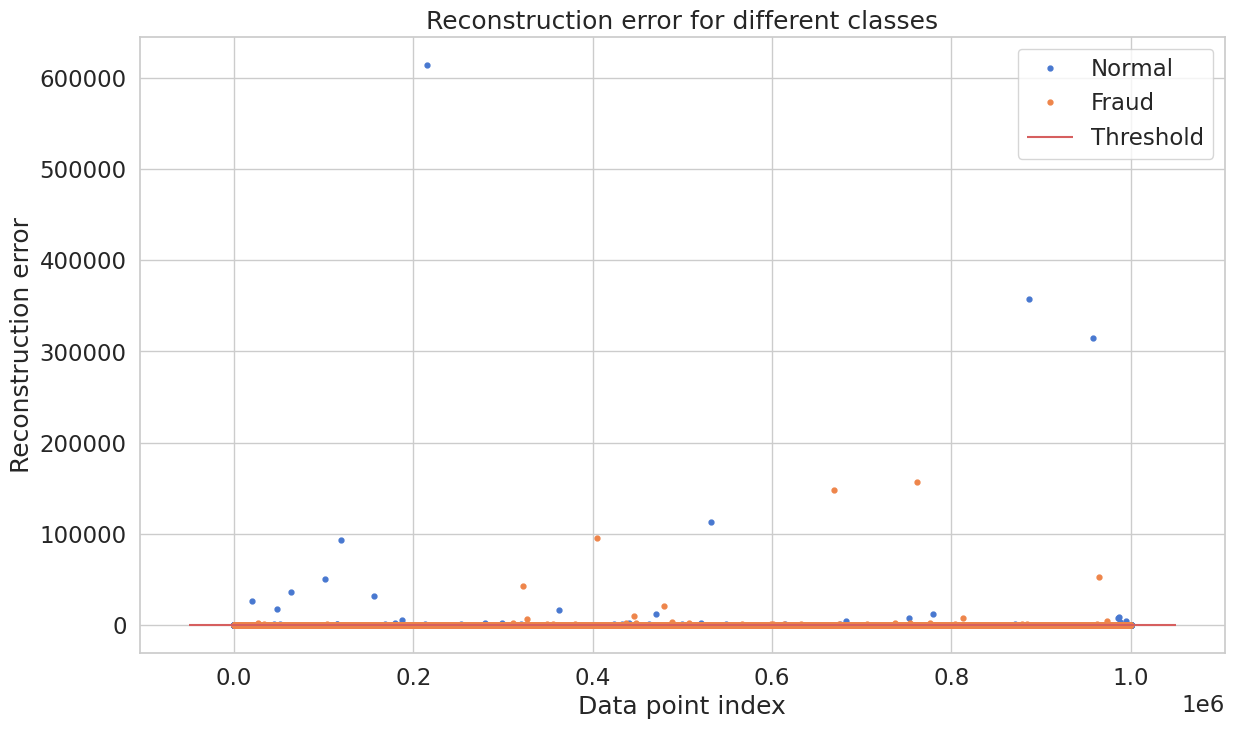

In [46]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

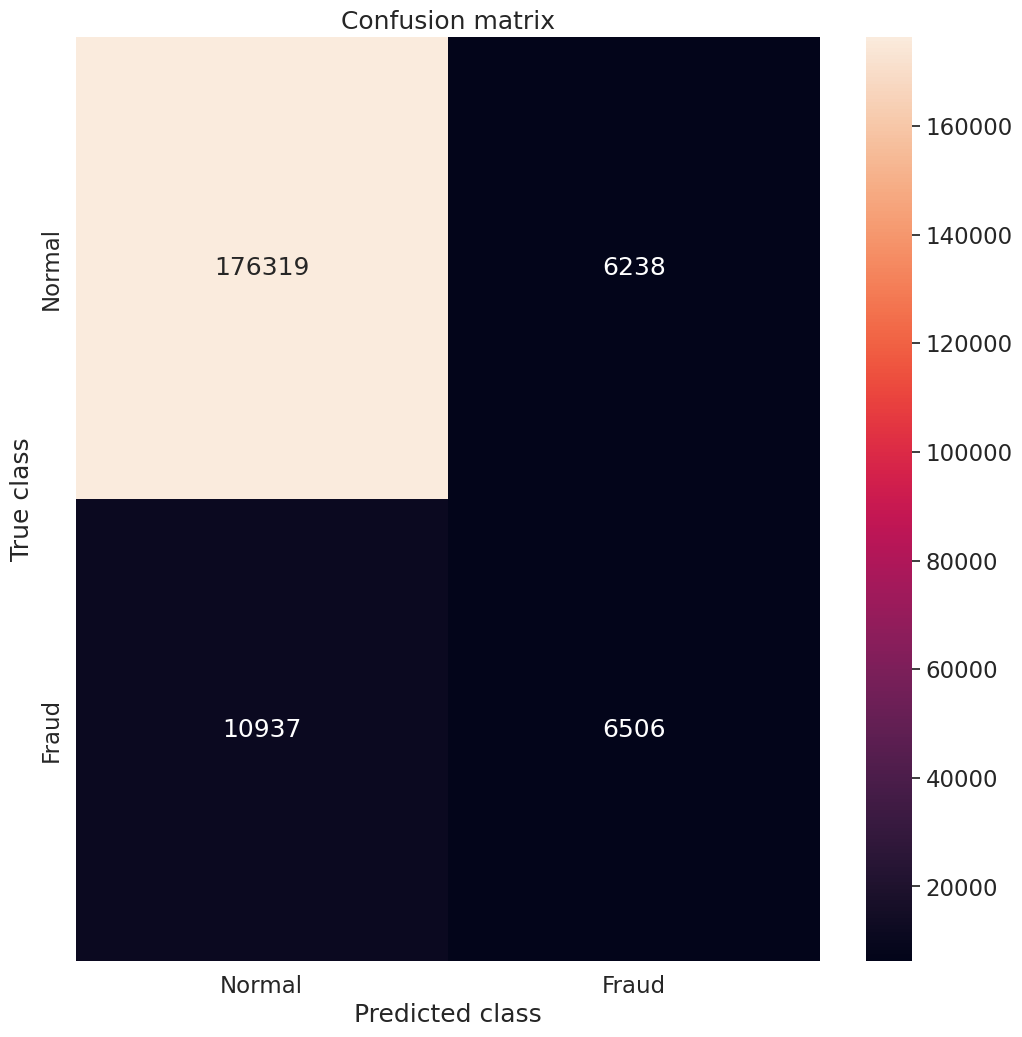

In [47]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.